In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from functools import reduce
import matplotlib.pyplot as plt


# Nice to have: show all columns in head()
pd.set_option("display.max_columns", 120)

DATA = Path("../data")
PROC = Path("../data/processed"); PROC.mkdir(parents=True, exist_ok=True)

def read_upper(path, dtypes=None):
    df = pd.read_csv(path, low_memory=False, dtype=dtypes or {})
    df.columns = df.columns.str.upper()
    return df

def parse_dt(df, cols=("START","STOP","DATE")):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce", utc=True)
    return df


In [2]:
encounters = read_upper(DATA/"encounters.csv")
patients  = read_upper(DATA/"patients.csv")
observations  = read_upper(DATA/"observations.csv")

encounters = parse_dt(encounters, cols=("START","STOP"))
patients  = parse_dt(patients,  cols=("START","STOP","DATE"))
observations  = parse_dt(observations,  cols=("DATE","START","STOP"))  # some exports have START/STOP here too

print("Patients:", patients.shape)
print("Encounters:", encounters.shape)
print("Observations:", observations.shape)

observations.head()



Patients: (22025, 28)
Encounters: (1320125, 15)
Observations: (808912, 9)


,DATE,PATIENT,ENCOUNTER,CATEGORY,CODE,DESCRIPTION,VALUE,UNITS,TYPE
0,2015-12-22 13:05:42+00:00,5e944684-ae0a-2387-5a4a-f4d421b0220c,5e944684-ae0a-2387-6dd3-95a8d8cd5575,vital-signs,8302-2,Body Height,107.4,cm,numeric
1,2015-12-22 13:05:42+00:00,5e944684-ae0a-2387-5a4a-f4d421b0220c,5e944684-ae0a-2387-6dd3-95a8d8cd5575,vital-signs,72514-3,Pain severity - 0-10 verbal numeric rating [Sc...,2.0,{score},numeric
2,2015-12-22 13:05:42+00:00,5e944684-ae0a-2387-5a4a-f4d421b0220c,5e944684-ae0a-2387-6dd3-95a8d8cd5575,vital-signs,29463-7,Body Weight,17.5,kg,numeric
3,2015-12-22 13:05:42+00:00,5e944684-ae0a-2387-5a4a-f4d421b0220c,5e944684-ae0a-2387-6dd3-95a8d8cd5575,vital-signs,39156-5,Body mass index (BMI) [Ratio],15.2,kg/m2,numeric
4,2015-12-22 13:05:42+00:00,5e944684-ae0a-2387-5a4a-f4d421b0220c,5e944684-ae0a-2387-6dd3-95a8d8cd5575,vital-signs,59576-9,Body mass index (BMI) [Percentile] Per age and...,50.9,%,numeric


In [3]:
# Number of unique patients
patients['ID'].nunique()

# Number of encounters per patient (first 5)
encounters_per_patient = encounters.groupby('PATIENT').size().head()
print(encounters_per_patient)

# Check a few columns
print(patients.columns)
print(encounters.columns)
print(observations.columns)

PATIENT
00010e8f-590e-3608-5307-0c075d7b83b6     27
00037657-224c-8a27-8e00-252779d41cc3     36
0004e2d2-969c-2b8e-b5c3-b1cc51eac06a     72
00070edc-4a3d-6dcb-de91-39d828ea23c5    544
00097b68-2bce-3e49-4b50-c28f44deed0b    302
dtype: int64
Index(['ID', 'BIRTHDATE', 'DEATHDATE', 'SSN', 'DRIVERS', 'PASSPORT', 'PREFIX',
       'FIRST', 'MIDDLE', 'LAST', 'SUFFIX', 'MAIDEN', 'MARITAL', 'RACE',
       'ETHNICITY', 'GENDER', 'BIRTHPLACE', 'ADDRESS', 'CITY', 'STATE',
       'COUNTY', 'FIPS', 'ZIP', 'LAT', 'LON', 'HEALTHCARE_EXPENSES',
       'HEALTHCARE_COVERAGE', 'INCOME'],
      dtype='object')
Index(['ID', 'START', 'STOP', 'PATIENT', 'ORGANIZATION', 'PROVIDER', 'PAYER',
       'ENCOUNTERCLASS', 'CODE', 'DESCRIPTION', 'BASE_ENCOUNTER_COST',
       'TOTAL_CLAIM_COST', 'PAYER_COVERAGE', 'REASONCODE',
       'REASONDESCRIPTION'],
      dtype='object')
Index(['DATE', 'PATIENT', 'ENCOUNTER', 'CATEGORY', 'CODE', 'DESCRIPTION',
       'VALUE', 'UNITS', 'TYPE'],
      dtype='object')


In [4]:
# Filter for inpatient encounters (hospital admissions/discharges):
inpatient = encounters[encounters['ENCOUNTERCLASS'] == 'inpatient'].copy()


In [5]:
# Convert START and STOP times to datetime:
inpatient['START'] = pd.to_datetime(inpatient['START'])
inpatient['STOP']  = pd.to_datetime(inpatient['STOP'])


In [16]:
# Create the “readmission within 30 days” label
inpatient = inpatient.sort_values(['PATIENT', 'START'])
inpatient['NEXT_START'] = inpatient.groupby('PATIENT')['START'].shift(-1)
inpatient['READMIT_30D'] = (
    (inpatient['NEXT_START'] - inpatient['STOP']).dt.days <= 30
) & (
    (inpatient['NEXT_START'] - inpatient['STOP']).dt.days > 0
)
inpatient['READMIT_30D'] = inpatient['READMIT_30D'].fillna(False).astype(int)


In [17]:
# --- feature engineering: merge encounters + patients + observations ---

# 1) Patient demographics → encounters (your current approach)
patients['BIRTHDATE'] = pd.to_datetime(patients['BIRTHDATE'], errors='coerce', utc=True)
patients['AGE'] = (pd.Timestamp('now', tz='UTC') - patients['BIRTHDATE']).dt.days / 365.25

data = inpatient.merge(
    patients[['ID', 'AGE', 'GENDER', 'RACE', 'ETHNICITY']],
    left_on='PATIENT', right_on='ID', how='left',
    suffixes=('', '_PATIENT')  # avoid name clashes if any
)


In [18]:
# ========= Focus: CATEGORY features from observations =========

# Keep only obs tied to the inpatient encounters we model
enc_ids = set(inpatient['ID'])
obs_cat = observations[observations['ENCOUNTER'].isin(enc_ids)].copy()

# Basic hygiene
for c in ('DATE',):
    if c in obs_cat.columns:
        obs_cat[c] = pd.to_datetime(obs_cat[c], errors='coerce', utc=True)

# 1) Raw category counts per encounter  -> OBS_CATCOUNT_<category>
cat_counts = (
    pd.crosstab(obs_cat['ENCOUNTER'], obs_cat['CATEGORY'])
      .add_prefix('OBS_CATCOUNT_')
)

# 2) Binary “any in category” flags     -> OBS_CATANY_<category>
cat_any = (cat_counts > 0).astype(int)
cat_any.columns = [c.replace('OBS_CATCOUNT_', 'OBS_CATANY_') for c in cat_any.columns]

# 3) Totals and proportions             -> OBS_CATPROP_<category>
totals = cat_counts.sum(axis=1).rename('OBS_CATTOTAL')
with np.errstate(divide='ignore', invalid='ignore'):
    cat_prop = cat_counts.div(totals, axis=0).fillna(0.0)
cat_prop.columns = [c.replace('OBS_CATCOUNT_', 'OBS_CATPROP_') for c in cat_prop.columns]

# 4) Normalize by length of stay (per-day rates) -> OBS_CATPERDAY_<category>
enc_los = (
    inpatient[['ID','START','STOP']]
      .assign(LOS_DAYS=lambda d: ((d['STOP'] - d['START']).dt.total_seconds() / 86400.0).clip(lower=1/24))
      .rename(columns={'ID':'ENCOUNTER'})
      .set_index('ENCOUNTER')
)[['LOS_DAYS']]

cat_counts_los = cat_counts.join(enc_los, how='left')
with np.errstate(divide='ignore', invalid='ignore'):
    cat_perday = cat_counts_los.drop(columns=['LOS_DAYS']).div(cat_counts_los['LOS_DAYS'], axis=0).fillna(0.0)
cat_perday.columns = [c.replace('OBS_CATCOUNT_', 'OBS_CATPERDAY_') for c in cat_perday.columns]

# Combine all CATEGORY-derived features
cat_feats = (
    totals.to_frame()
    .join(cat_counts, how='left')
    .join(cat_any,    how='left')
    .join(cat_prop,   how='left')
    .join(cat_perday, how='left')
    .reset_index()   # ENCOUNTER back to a column for merge
)

# 5) Merge into encounter+patient table
data = data.merge(cat_feats, left_on='ID', right_on='ENCOUNTER', how='left')

# 6) Rebuild X with demographics + CATEGORY features
base_cols = ['AGE','GENDER','RACE','ETHNICITY']
cat_cols  = [c for c in data.columns if c.startswith(('OBS_CATTOTAL','OBS_CATCOUNT_','OBS_CATANY_','OBS_CATPROP_','OBS_CATPERDAY_'))]

feature_cols = [c for c in base_cols + cat_cols if c in data.columns]
X = data[feature_cols].copy()
y = data['READMIT_30D'].astype(int)

# One-hot encode demographics; categorical columns among demographics become dummies
X = pd.get_dummies(X, columns=['GENDER','RACE','ETHNICITY'], drop_first=True)

print("X shape:", X.shape, "| y shape:", y.shape)
print("Sample CATEGORY cols:", [c for c in X.columns if c.startswith('OBS_CAT')][:10])


X shape: (21789, 9) | y shape: (21789,)
Sample CATEGORY cols: ['OBS_CATTOTAL']


In [19]:
X.head()

,AGE,OBS_CATTOTAL,GENDER_M,RACE_black,RACE_hawaiian,RACE_native,RACE_other,RACE_white,ETHNICITY_nonhispanic
0,77.445585,NaN,True,False,False,False,False,True,True
1,71.471595,NaN,False,False,False,False,False,True,True
2,68.903491,NaN,True,False,False,False,False,True,True
3,105.409993,NaN,True,False,False,False,False,False,True
4,105.409993,NaN,True,False,False,False,False,False,True


In [20]:
y.value_counts()

READMIT_30D
0    17948
1     3841
Name: count, dtype: int64

# Logistic Regression

In [26]:
# Baseline logistic model on merged (encounters+patients+observations) data

from sklearn.model_selection import GroupShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix
import numpy as np
import pandas as pd

# X, y, and data are from the previous merge step.
# Ensure X is all numeric (we already used get_dummies earlier)
assert np.issubdtype(X.dtypes.values[0], np.number) or X.select_dtypes(exclude=np.number).empty, \
    "X still has non-numeric columns; run pd.get_dummies first."

# Group-aware split to avoid patient leakage
groups = data['PATIENT'].astype(str)
gss = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train = X.iloc[train_idx].copy()
X_test  = X.iloc[test_idx].copy()
y_train = y.iloc[train_idx].astype(int)
y_test  = y.iloc[test_idx].astype(int)

print("Shapes → X_train:", X_train.shape, "X_test:", X_test.shape)
print("Label balance → train:", y_train.value_counts().to_dict(),
      "test:", y_test.value_counts().to_dict())

# Simple pipeline: impute -> scale -> logistic
pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=True)),
    ("logreg", LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        max_iter=2000,
        class_weight="balanced",
        random_state=42
    )),
])

pipe.fit(X_train, y_train)

# Predictions & metrics
y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]

print("Test prevalence (positive rate):", y_test.mean().round(4))
print("ROC AUC:", roc_auc_score(y_test, y_prob).round(4))
print("PR AUC (average precision):", average_precision_score(y_test, y_prob).round(4))
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# Coefficients & feature importance (robust to length mismatch) 
logreg = pipe.named_steps["logreg"]

# Use the training columns (not full X) to avoid leakage/mismatch
feat = X_train.columns.to_numpy()

# Sanity check: match feature count to estimator
n_est = logreg.n_features_in_
coef = logreg.coef_.ravel()

if len(feat) != n_est:
    # Get the number of columns actually passed to the estimator
    Xtr_proc = pipe[:-1].transform(X_train)  # imputer + scaler
    n_proc = Xtr_proc.shape[1]
    # If we somehow can't align names, fall back to generic names
    if n_proc == coef.size:
        feat = np.array([f"feat_{i}" for i in range(n_proc)])
    else:
        raise RuntimeError(
            f"Feature-name/coef length mismatch: names={len(feat)}, "
            f"est_in_={n_est}, processed={n_proc}, coef={coef.size}"
        )

coef_df = pd.DataFrame({"feature": feat, "coef": coef})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df["odds_ratio_per_1sd"] = np.exp(coef_df["coef"])  # after StandardScaler

coef_df_sorted = coef_df.sort_values("abs_coef", ascending=False)

print("\nTop 15 features by |coef| (standardized):")
print(coef_df_sorted.head(15)[["feature", "coef", "odds_ratio_per_1sd"]].to_string(index=False))

# (optional) intercept for completeness
intercept = float(logreg.intercept_)
print(f"\nIntercept (log-odds): {intercept:.4f}")

Shapes → X_train: (15706, 9) X_test: (6083, 9)
Label balance → train: {0: 12725, 1: 2981} test: {0: 5223, 1: 860}
Test prevalence (positive rate): 0.1414
ROC AUC: 0.6693
PR AUC (average precision): 0.2262

Classification report:
               precision    recall  f1-score   support

           0     0.8957    0.6427    0.7484      5223
           1     0.2009    0.5453    0.2936       860

    accuracy                         0.6290      6083
   macro avg     0.5483    0.5940    0.5210      6083
weighted avg     0.7974    0.6290    0.6841      6083

Confusion matrix:
 [[3357 1866]
 [ 391  469]]

Top 15 features by |coef| (standardized):
feature      coef  odds_ratio_per_1sd
 feat_0  0.720352            2.055157
 feat_1  0.361653            1.435701
 feat_4 -0.265124            0.767111
 feat_2 -0.079722            0.923373
 feat_6 -0.056082            0.945461
 feat_3 -0.050532            0.950724
 feat_7 -0.039670            0.961107
 feat_5 -0.009448            0.990596

Intercept (

C:\Users\Vishal Yadav\anaconda3\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['OBS_CATTOTAL']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\Vishal Yadav\anaconda3\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['OBS_CATTOTAL']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\Vishal Yadav\anaconda3\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['OBS_CATTOTAL']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\Vishal Yadav\anaconda3\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['OBS_CATTOTAL']. At least one non-missing value is needed for imputation with strategy='median'.
 

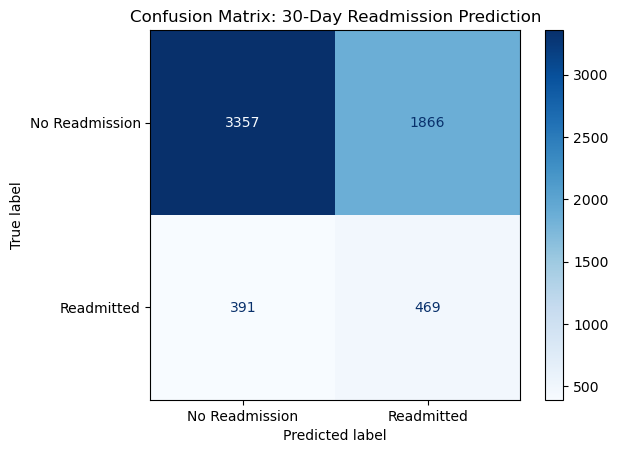

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Readmission", "Readmitted"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix: 30-Day Readmission Prediction")
plt.show()

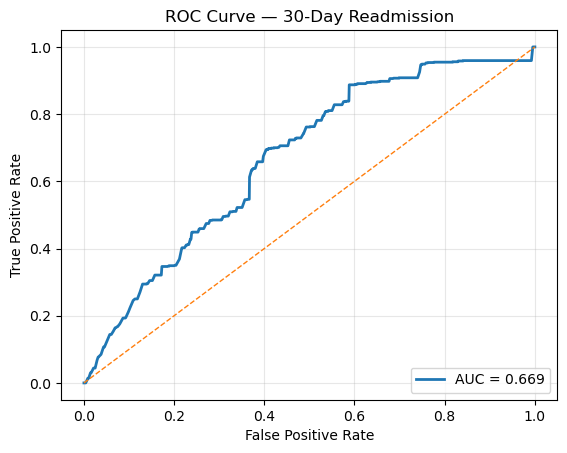

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 1) ROC points + AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

# 2) Plot
plt.figure()
plt.plot(fpr, tpr, linewidth=2, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — 30-Day Readmission")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()


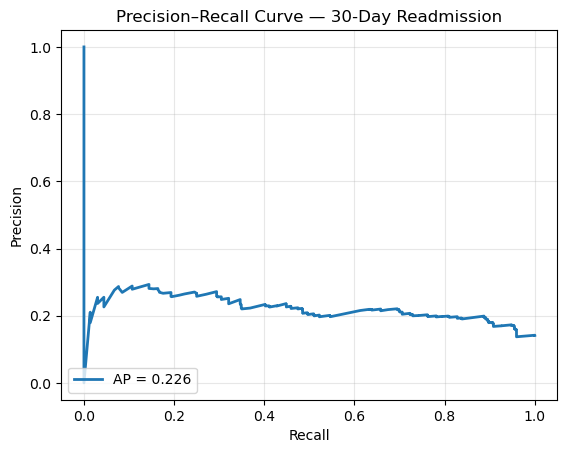

In [23]:
from sklearn.metrics import precision_recall_curve, average_precision_score

prec, rec, _ = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)

plt.figure()
plt.plot(rec, prec, linewidth=2, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — 30-Day Readmission")
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.show()


# Random Forest

Shapes → X_train: (15706, 9) X_test: (6083, 9)
Label balance → train: {0: 12725, 1: 2981} test: {0: 5223, 1: 860}


C:\Users\Vishal Yadav\anaconda3\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['OBS_CATTOTAL']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\Vishal Yadav\anaconda3\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['OBS_CATTOTAL']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\Vishal Yadav\anaconda3\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['OBS_CATTOTAL']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(



Test prevalence (positive rate): 0.1414
ROC AUC: 0.5924
PR  AUC (avg precision): 0.1742

Classification report:
               precision    recall  f1-score   support

           0     0.8619    0.9081    0.8844      5223
           1     0.1724    0.1163    0.1389       860

    accuracy                         0.7962      6083
   macro avg     0.5172    0.5122    0.5116      6083
weighted avg     0.7644    0.7962    0.7790      6083

Confusion matrix:
 [[4743  480]
 [ 760  100]]


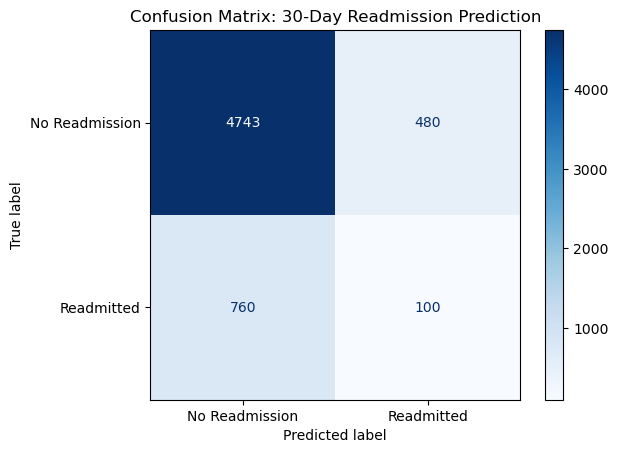

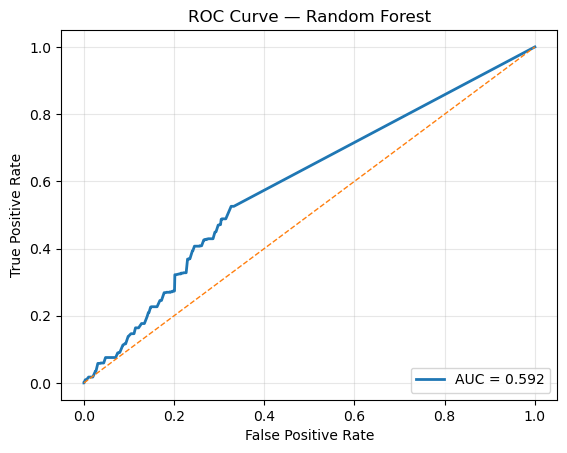

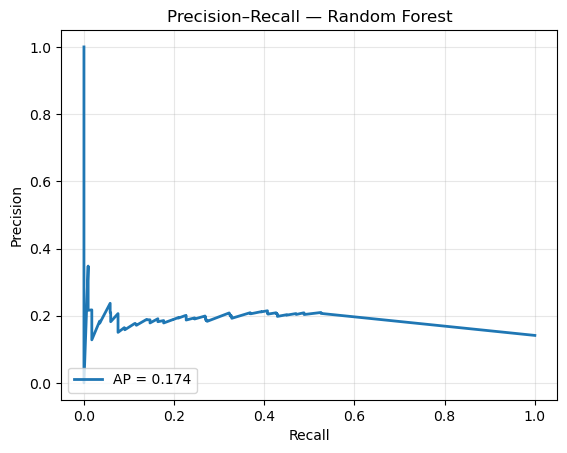

[warn] importance/name length mismatch: imp=8, names=9. Using generic names.

Top 20 features by importance:
feature  importance
 feat_0    0.888407
 feat_1    0.082578
 feat_7    0.009115
 feat_6    0.008647
 feat_2    0.005091
 feat_3    0.003077
 feat_5    0.001909
 feat_4    0.001177


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, roc_auc_score, average_precision_score,
    confusion_matrix, roc_curve, precision_recall_curve
)
from sklearn.model_selection import train_test_split


# Ensure X, X_train, X_test keep names
if not hasattr(X, "columns"):
    X = pd.DataFrame(X)
if not hasattr(X_train, "columns"):
    X_train = pd.DataFrame(X_train, columns=X.columns)
    X_test  = pd.DataFrame(X_test,  columns=X.columns)


# --- Ensure we have train/test splits and correct dtypes ---
try:
    _ = (X_train, X_test, y_train, y_test)
except NameError:
    # Fallback split if not already defined
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, random_state=42, stratify=y
    )


# Coerce y to 0/1 ints
y_train = pd.Series(pd.to_numeric(y_train, errors="coerce")).fillna(0).astype(int)
y_test  = pd.Series(pd.to_numeric(y_test,  errors="coerce")).fillna(0).astype(int)

print("Shapes → X_train:", X_train.shape, "X_test:", X_test.shape)
print("Label balance → train:", y_train.value_counts().to_dict(),
      "test:", y_test.value_counts().to_dict())

# --- Random Forest pipeline (trees need imputation, no scaling needed) ---
rf_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("rf", RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features="sqrt",
        class_weight="balanced_subsample",
        n_jobs=-1,
        random_state=42
    ))
])

try:
    # Train
    rf_pipe.fit(X_train, y_train)

    # Predict
    y_pred = rf_pipe.predict(X_test)
    y_prob = rf_pipe.predict_proba(X_test)[:, 1]

    # Metrics
    print("\nTest prevalence (positive rate):", y_test.mean().round(4))
    print("ROC AUC:", roc_auc_score(y_test, y_prob).round(4))
    print("PR  AUC (avg precision):", average_precision_score(y_test, y_prob).round(4))
    print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Readmission", "Readmitted"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix: 30-Day Readmission Prediction")
    plt.show()

    # --- ROC curve ---
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, linewidth=2, label=f"AUC = {auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC Curve — Random Forest")
    plt.legend(loc="lower right"); plt.grid(True, alpha=0.3)
    plt.show()

    # --- Precision–Recall curve ---
    prec, rec, _ = precision_recall_curve(y_test, y_prob)
    ap = average_precision_score(y_test, y_prob)
    plt.figure()
    plt.plot(rec, prec, linewidth=2, label=f"AP = {ap:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title("Precision–Recall — Random Forest")
    plt.legend(loc="lower left"); plt.grid(True, alpha=0.3)
    plt.show()

    # --- Feature importances (guard against length mismatch) ---
    rf = rf_pipe.named_steps["rf"]
    imp = rf.feature_importances_

    # feat_names = X_train.columns.to_numpy()             # real feature names
    # imp_df = (
    #     pd.DataFrame({"feature": feat_names, "importance": imp})
    #       .sort_values("importance", ascending=False)
    # )
    # print(imp_df.head(20).to_string(index=False))


    
    # If X_train is a DataFrame, we have names; else fallback to generic names
    if hasattr(X_train, "columns"):
        feat_names = np.array(X_train.columns)
    else:
        feat_names = np.array([f"feat_{i}" for i in range(imp.size)])

    if imp.size != feat_names.size:
        print(f"[warn] importance/name length mismatch: imp={imp.size}, names={feat_names.size}. Using generic names.")
        feat_names = np.array([f"feat_{i}" for i in range(imp.size)])

    imp_df = pd.DataFrame({"feature": feat_names, "importance": imp}) \
               .sort_values("importance", ascending=False)

    print("\nTop 20 features by importance:")
    print(imp_df.head(20).to_string(index=False))

except Exception as e:
    print("\n[ERROR] Random Forest pipeline failed:")
    print(type(e).__name__, "—", e)
    # Helpful debugging prints
    print("X_train dtypes:\n", getattr(X_train, "dtypes", "N/A"))
    print("Any non-numeric columns?",
          not getattr(X_train.select_dtypes(exclude=np.number), "empty", True))


In [28]:
X.columns

Index(['AGE', 'OBS_CATTOTAL', 'GENDER_M', 'RACE_black', 'RACE_hawaiian',
       'RACE_native', 'RACE_other', 'RACE_white', 'ETHNICITY_nonhispanic'],
      dtype='object')